# Import data

In [244]:
import pandas as pd

# Read all sheets into a dictionary of DataFrames
# dfs = pd.read_excel('results-12-19.xlsx', sheet_name=None)
dfs = pd.read_excel('results-12-22.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs.keys())

dict_keys(['vary |D| size', 'vary K', 'vary beta', 'support increase', 'support decrease', 'confidence increase', 'confidence decrease', 'supp inc | conf inc', 'supp inc | conf dec', 'supp dec | conf inc', 'supp dec | conf dec', '(old change) supp inc|conf inc', '(old change) supp dec|conf dec'])


In [185]:
import matplotlib.pyplot as plt
import numpy as np

# Set default figure size (width, height in inches)
plt.rcParams['figure.figsize'] = [4, 3]

plt.rcParams['font.size'] = 16

plt.rcParams['lines.markersize'] = 10  # Default marker size is 6

In [210]:
VERBOSE = False

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorMap = {
    "batch": colors[1],
    "IncMiner1.0": colors[0],
    "IncMiner": colors[0],
    "IncMiner0.7": colors[2],
    "IncMinerNS": colors[4],
    "IApriori": colors[3],
}

markerMap = {
    "batch": '^',
    "IncMiner1.0": 's',
    "IncMiner": 's',
    "IncMiner0.7": 'v',
    "IncMinerNS": '*',
    "IApriori": '+',
    
}

In [283]:
ylabel_time = "Running time (s)"

In [26]:
def post_process(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['supportScale'] = _df['new support'] / _df['old support']

    # 2. Compute absolute difference of 'new confidence' over 'old confidence'
    _df['confDiff'] = _df['new confidence'] - _df['old confidence']
    
    # 3. Assign new label name
    _df['label'] = _df['Baseline'] + _df['beta'].fillna('').astype(str)
    
    # 4. Convert Mining time scale
    _df['time'] = _df['Mining time'] / 1000

    return _df

# Exp-3 : vary K

In [211]:
tab = 'vary K'
df = dfs[tab]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,sample number,minimal REE number,prune REE number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,1,0.7,20,61552,...,4938,6978,4,1000839,197.330358,177.228312,1.0,-0.3,IncMiner0.7,61.552
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,2,0.7,20,73697,...,4666,7251,4,1000840,197.192966,176.426808,1.0,-0.3,IncMiner0.7,73.697
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,74284,...,4429,7222,4,1000841,210.851518,190.145606,1.0,-0.3,IncMiner0.7,74.284
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,4,0.7,20,76793,...,4254,7257,4,1000842,932.370173,911.622714,1.0,-0.3,IncMiner0.7,76.793
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,5,0.7,20,78467,...,4080,7131,4,1000843,1458.229627,1437.727566,1.0,-0.3,IncMiner0.7,78.467


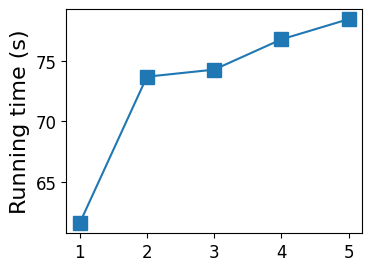

In [222]:
select = df['Baseline'] == 'IncMiner'
x = df[select]["K"]
y = df[select]["time"] 

plt.figure()
plt.plot(x, y, marker='s')  
plt.ylabel('Running time (s)')  # Label for the y-axis

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

if VERBOSE:
    plt.xlabel('K')  # Label for the x-axis
    plt.title('K vs Mining Time')  # Title of the plot
    
outfile = "plots/exp3_hospital_k_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    

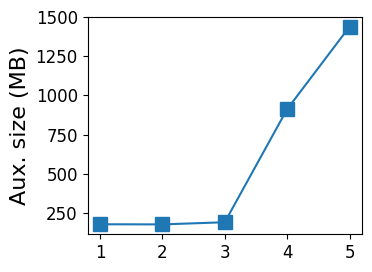

In [220]:
X = df[select]["K"]
Y = df[select]["auxiliary size"] 
# Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker='s') 
plt.ylabel('Aux. size (MB)')  # Label for the y-axis

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_storage.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

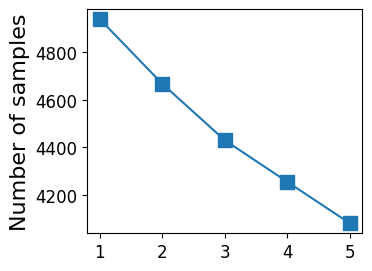

In [221]:
X = df[select]["K"]
Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker="s")  # You can change the color and line style
plt.ylabel('Number of samples')  # Label for the y-axis

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_samples.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

## Vary beta

In [223]:
df = dfs["vary beta"]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,sample number,minimal REE number,prune REE number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.6,20,65068,...,4429,6645,4,1000846,209.588505,190.145606,1.0,-0.3,IncMiner0.6,65.068
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,74419,...,4429,7200,4,1000847,210.797297,190.145606,1.0,-0.3,IncMiner0.7,74.419
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.8,20,84375,...,4429,7794,4,1000848,212.135976,190.145606,1.0,-0.3,IncMiner0.8,84.375
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.9,20,96857,...,4429,8464,4,1000849,213.880294,190.145606,1.0,-0.3,IncMiner0.9,96.857
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,1.0,20,110784,...,4429,9034,4,1000850,215.273599,190.145606,1.0,-0.3,IncMiner1.0,110.784


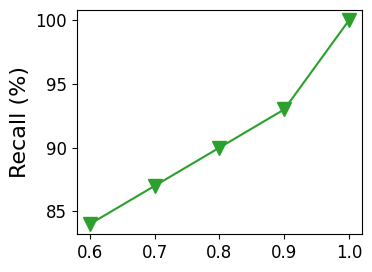

In [232]:

# Assuming 'Sample number' is a column in df and 'Mining time' is another column
X = df["beta"]
Y = (df["recall rate"] * 100).round().astype(int)

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label]) 
plt.ylabel('Recall (%)')  # Label for the y-axis

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_recall.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')     

# Show the plot
plt.show()

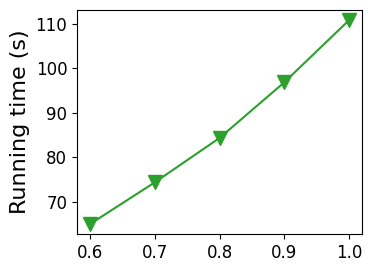

In [233]:
X = df["beta"]
Y = df["time"]

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label]) 
plt.ylabel('Running time (s)')  # Label for the y-axis

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

## Comments

Now the mining time is too fast. May use a larger dataset.

# Exp-2

## Vary |D|

In [299]:
tab = 'vary |D| size'

df = dfs[tab]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,|D| size,Mining time,sample number,minimal REE number,prune REE number,output size,auxiliary size,taskId,supportScale,confDiff,label,time
0,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.2,6490,29,2151,0,46.926207,40.061395,1000813,0.1,-0.1,IncMiner0.7,6.490
1,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.4,15803,88,2346,0,85.018553,77.698296,1000814,0.1,-0.1,IncMiner0.7,15.803
2,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.6,25207,88,2604,0,121.910717,113.732244,1000815,0.1,-0.1,IncMiner0.7,25.207
3,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.8,33438,85,2567,0,156.848563,148.777529,1000816,0.1,-0.1,IncMiner0.7,33.438
4,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,1.0,42777,84,2426,2,190.722912,183.038933,1000817,0.1,-0.1,IncMiner0.7,42.777
5,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.2,8487,29,2611,0,48.034082,40.061395,1000818,0.1,-0.1,IncMiner1.0,8.487
6,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.4,19674,88,2884,0,86.257845,77.698296,1000819,0.1,-0.1,IncMiner1.0,19.674
7,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.6,30656,88,3104,0,123.053940,113.732244,1000820,0.1,-0.1,IncMiner1.0,30.656
8,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.8,42193,85,3068,0,157.984018,148.777529,1000821,0.1,-0.1,IncMiner1.0,42.193
9,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,1.0,52908,84,3027,2,192.100856,183.038933,1000822,0.1,-0.1,IncMiner1.0,52.908


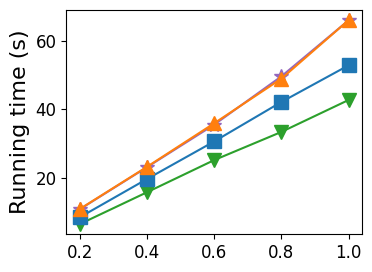

In [300]:
# Group by the "label" column
groups = df.groupby('label')

plt.figure()
for label, group in groups:
    plt.plot(group['|D| size'], group['time'], label=label, color=colorMap[label], marker=markerMap[label]) 

# Plot the data
if VERBOSE:
    plt.legend()
    plt.xlabel('|D|')  # Label for the x-axis
plt.ylabel(ylabel_time)

plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

outfile = "plots/exp2_dblp_d_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()



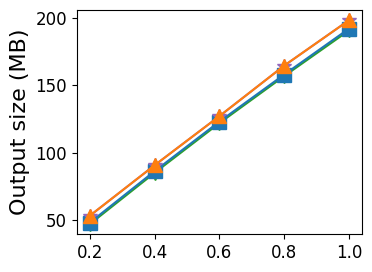

In [242]:
plt.figure()
for label, group in groups:
    plt.plot(group['|D| size'], group['output size'], label=label, color=colorMap[label], marker=markerMap[label]) 

# Plot the data
plt.ylabel('Output size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

outfile = "plots/exp2_dblp_d_output.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      
    
# Show the plot
plt.show()

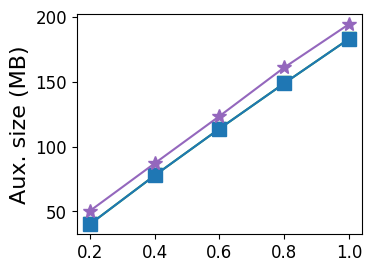

In [240]:
plt.figure()
for label, group in groups:
    if label == 'batch':
        continue
    plt.plot(group['|D| size'], group['auxiliary size'], label=label, color=colorMap[label], marker=markerMap[label]) 

# Plot the data
plt.ylabel('Aux. size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  

outfile = "plots/exp2_dblp_d_aux.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      

# Show the plot
plt.show()

# Exp-1

## support increase

In [174]:
tab = 'support increase'
df = dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,0.7,20,0,1949,4,4360,1000852,292.876556,285.577252,10.0,0.0,IncMiner0.7,0.000
1,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,0.7,20,0,164,4,4360,1000853,286.258027,285.577252,100.0,0.0,IncMiner0.7,0.000
2,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,0.7,20,0,135,4,4360,1000854,286.169531,285.577252,1000.0,0.0,IncMiner0.7,0.000
3,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,0.7,20,0,80,4,4360,1000855,285.941710,285.577252,10000.0,0.0,IncMiner0.7,0.000
4,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,NaN,20,0,1949,4,4360,1000856,292.876556,285.577252,10.0,0.0,IncMiner,0.000
5,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,NaN,20,0,164,4,4360,1000857,286.258027,285.577252,100.0,0.0,IncMiner,0.000
6,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,NaN,20,0,135,4,4360,1000858,286.169531,285.577252,1000.0,0.0,IncMiner,0.000
7,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,NaN,20,0,80,4,4360,1000859,285.941710,285.577252,10000.0,0.0,IncMiner,0.000
8,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMinerNS,3,NaN,20,0,1949,4,4360,1000860,292.876556,285.577252,10.0,0.0,IncMinerNS,0.000
9,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMinerNS,3,NaN,20,0,164,4,4360,1000861,286.258027,285.577252,100.0,0.0,IncMinerNS,0.000


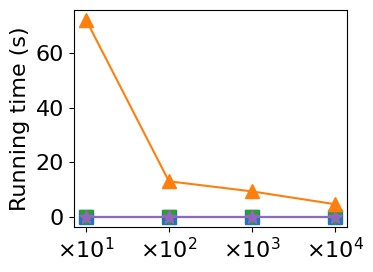

In [175]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    X = group['supportScale']
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label]) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_increase_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

## support decrease

In [176]:
tab = 'support decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,0.7,20,5004,30,673,32,1000869,171.854549,171.756176,0.1000,0.0,IncMiner0.7,5.004
1,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,0.7,20,15167,138,936,32,1000870,173.121503,172.677629,0.0100,0.0,IncMiner0.7,15.167
2,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,0.7,20,101409,1903,300,32,1000871,177.361353,170.336308,0.0010,0.0,IncMiner0.7,101.409
3,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,0.7,20,162302,2364,6,32,1000872,177.944247,169.355851,0.0001,0.0,IncMiner0.7,162.302
4,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,NaN,20,5047,30,673,32,1000873,171.854549,171.756176,0.1000,0.0,IncMiner,5.047
5,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,NaN,20,15344,138,936,32,1000874,173.121503,172.677629,0.0100,0.0,IncMiner,15.344
6,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,NaN,20,100691,1903,300,32,1000875,177.361353,170.336308,0.0010,0.0,IncMiner,100.691
7,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,NaN,20,162457,2364,6,32,1000876,177.944247,169.355851,0.0001,0.0,IncMiner,162.457
8,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMinerNS,3,NaN,20,4956,30,673,32,1000877,171.854549,171.756176,0.1000,0.0,IncMinerNS,4.956
9,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMinerNS,3,NaN,20,14274,138,936,32,1000878,173.121503,172.677629,0.0100,0.0,IncMinerNS,14.274


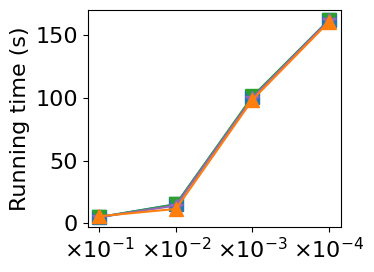

In [177]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()  # Adjust the figure size if needed

for label, group in groups:
    X = group['supportScale']
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label]) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_decrease_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

## confidence increase

In [284]:
tab = 'confidence increase'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,0.7,20,10348,1760,4,2297,1000886,200.769535,194.457306,1.0,0.05,IncMiner0.7,10.348
1,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,0.7,20,22825,1848,4,2496,1000887,202.548604,195.974273,1.0,0.10,IncMiner0.7,22.825
2,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,0.7,20,40148,1766,4,2756,1000888,204.311934,197.958477,1.0,0.15,IncMiner0.7,40.148
3,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,0.7,20,62722,1681,4,3010,1000889,208.745840,202.647288,1.0,0.20,IncMiner0.7,62.722
4,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,0.7,20,130648,1405,4,3825,1000890,227.981372,222.828514,1.0,0.25,IncMiner0.7,130.648
5,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,NaN,20,9874,1760,4,2297,1000891,200.769535,194.457306,1.0,0.05,IncMiner,9.874
6,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,NaN,20,23297,1848,4,2496,1000892,202.548604,195.974273,1.0,0.10,IncMiner,23.297
7,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,NaN,20,39996,1766,4,2756,1000893,204.311934,197.958477,1.0,0.15,IncMiner,39.996
8,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,NaN,20,62620,1681,4,3010,1000894,208.745840,202.647288,1.0,0.20,IncMiner,62.620
9,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,NaN,20,129039,1405,4,3825,1000895,227.981372,222.828514,1.0,0.25,IncMiner,129.039


<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_78638/2664495442.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


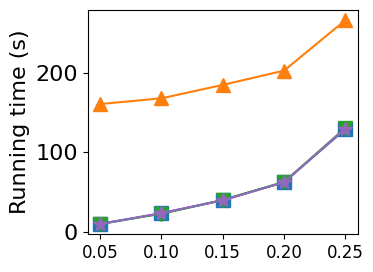

In [285]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label])

# Add plot labels and legend
plt.ylabel(ylabel_time)

if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
        
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_increase_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

## confidence decrease

In [286]:
tab = 'confidence decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,0.7,20,74491,4443,4,4379,1000907,235.441198,222.479539,1.0,-0.05,IncMiner0.7,74.491
1,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,0.7,20,82021,5050,4,4379,1000908,237.142997,222.479539,1.0,-0.10,IncMiner0.7,82.021
2,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,0.7,20,90073,6461,4,4379,1000909,241.075844,222.479539,1.0,-0.15,IncMiner0.7,90.073
3,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,0.7,20,94740,6932,4,4379,1000910,242.335038,222.479539,1.0,-0.20,IncMiner0.7,94.740
4,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,0.7,20,96121,7290,4,4379,1000911,243.332522,222.479539,1.0,-0.25,IncMiner0.7,96.121
5,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,NaN,20,128875,5852,4,4379,1000912,238.777879,222.479539,1.0,-0.05,IncMiner,128.875
6,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,NaN,20,139857,6687,4,4379,1000913,241.028486,222.479539,1.0,-0.10,IncMiner,139.857
7,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,NaN,20,144757,8392,4,4379,1000914,245.714448,222.479539,1.0,-0.15,IncMiner,144.757
8,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,NaN,20,140898,9020,4,4379,1000915,247.372401,222.479539,1.0,-0.20,IncMiner,140.898
9,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,NaN,20,145134,9528,4,4379,1000916,248.769385,222.479539,1.0,-0.25,IncMiner,145.134


<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_78638/767041638.py:15: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


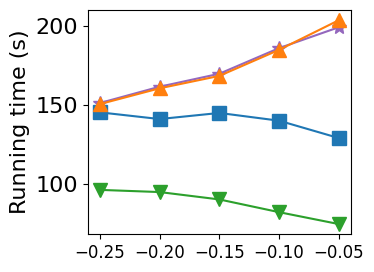

In [287]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label])

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis


if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_decrease_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
# Display the plot
plt.show()

## s+c+

In [288]:
tab = 'supp inc | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,0.7,20,7921,1291,461,2706,1000928,205.432906,200.653219,10.0,0.05,IncMiner0.7,7.921
1,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,0.7,20,1471,61,1650,2640,1000929,204.710849,204.439388,100.0,0.10,IncMiner0.7,1.471
2,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,0.7,20,772,20,1669,2626,1000930,204.555819,204.467310,1000.0,0.15,IncMiner0.7,0.772
3,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,0.7,20,696,13,1696,2627,1000931,204.632421,204.553029,10000.0,0.20,IncMiner0.7,0.696
4,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,NaN,20,8263,1291,461,2706,1000932,205.432906,200.653219,10.0,0.05,IncMiner,8.263
5,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,NaN,20,1657,61,1650,2640,1000933,204.710849,204.439388,100.0,0.10,IncMiner,1.657
6,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,NaN,20,638,20,1669,2626,1000934,204.555819,204.467310,1000.0,0.15,IncMiner,0.638
7,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,NaN,20,682,13,1696,2627,1000935,204.632421,204.553029,10000.0,0.20,IncMiner,0.682
8,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMinerNS,3,NaN,20,7865,1291,461,2622,1000936,204.741519,199.961832,10.0,0.05,IncMinerNS,7.865
9,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMinerNS,3,NaN,20,1725,61,1650,2622,1000937,204.585556,204.314095,100.0,0.10,IncMinerNS,1.725


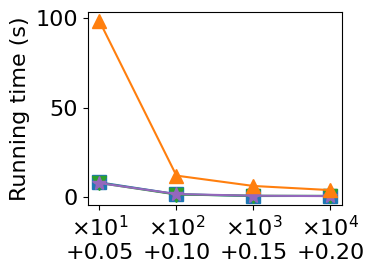

In [289]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

## S+C-

In [290]:
tab = 'supp inc | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,0.7,20,35112,4815,4,7076,1000945,439.639335,425.405519,10.0,-0.05,IncMiner0.7,35.112
1,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,0.7,20,38203,6468,4,7076,1000946,444.444035,425.405519,100.0,-0.10,IncMiner0.7,38.203
2,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,0.7,20,41421,9246,4,7076,1000947,452.580389,425.405519,1000.0,-0.15,IncMiner0.7,41.421
3,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,0.7,20,46118,10794,4,7076,1000948,456.864191,425.405519,10000.0,-0.20,IncMiner0.7,46.118
4,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,NaN,20,84479,7268,4,7076,1000949,445.406998,425.405519,10.0,-0.05,IncMiner,84.479
5,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,NaN,20,91213,9304,4,7076,1000950,451.140579,425.405519,100.0,-0.10,IncMiner,91.213
6,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,NaN,20,96573,12576,4,7076,1000951,460.514900,425.405519,1000.0,-0.15,IncMiner,96.573
7,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,NaN,20,102354,14402,4,7076,1000952,465.561750,425.405519,10000.0,-0.20,IncMiner,102.354
8,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMinerNS,3,NaN,20,103511,1809,24,5865,1000953,388.338009,381.152461,10.0,-0.05,IncMinerNS,103.511
9,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMinerNS,3,NaN,20,14458,122,276,3299,1000954,265.285500,264.716959,100.0,-0.10,IncMinerNS,14.458


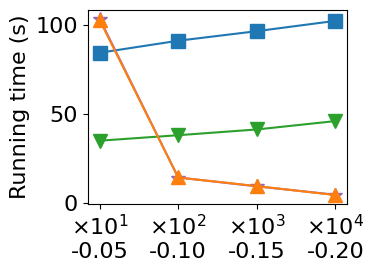

In [291]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s+c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

## S-C+

In [292]:
tab = 'supp dec | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,0.7,20,5165,30,674,133,1000962,172.572477,172.474104,0.1000,0.05,IncMiner0.7,5.165
1,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,0.7,20,14552,146,944,321,1000963,175.161844,174.689203,0.0100,0.10,IncMiner0.7,14.552
2,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,0.7,20,116063,1848,312,2599,1000964,199.247224,192.272351,0.0010,0.15,IncMiner0.7,116.063
3,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,0.7,20,203794,2125,6,3517,1000965,206.189782,198.222109,0.0001,0.20,IncMiner0.7,203.794
4,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,NaN,20,5002,30,674,133,1000966,172.572477,172.474104,0.1000,0.05,IncMiner,5.002
5,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,NaN,20,14611,146,944,321,1000967,175.161844,174.689203,0.0100,0.10,IncMiner,14.611
6,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,NaN,20,116497,1848,312,2599,1000968,199.247224,192.272351,0.0010,0.15,IncMiner,116.497
7,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,NaN,20,202983,2125,6,3517,1000969,206.189782,198.222109,0.0001,0.20,IncMiner,202.983
8,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMinerNS,3,NaN,20,5310,30,674,31,1000970,171.852614,171.754241,0.1000,0.05,IncMinerNS,5.310
9,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMinerNS,3,NaN,20,14669,146,944,31,1000971,173.160964,172.688323,0.0100,0.10,IncMinerNS,14.669


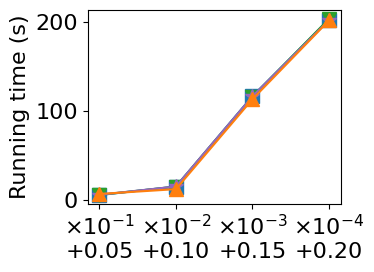

In [293]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s-c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

## S-C-

In [270]:
tab = 'supp dec | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,0.7,20,7733,612,591,2754,1000979,174.322888,172.433934,0.1000,-0.05,IncMiner0.7,7.733
1,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,0.7,20,12632,1569,278,3104,1000980,180.347924,175.555758,0.0100,-0.10,IncMiner0.7,12.632
2,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,0.7,20,75552,4305,16,4972,1000981,266.414660,252.012123,0.0010,-0.15,IncMiner0.7,75.552
3,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,0.7,20,69251,4959,2,4722,1000982,262.388706,246.085822,0.0001,-0.20,IncMiner0.7,69.251
4,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,NaN,20,7908,734,591,2754,1000983,174.669429,172.433934,0.1000,-0.05,IncMiner,7.908
5,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,NaN,20,13287,1702,278,3104,1000984,180.719843,175.555758,0.0100,-0.10,IncMiner,13.287
6,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,NaN,20,75953,4572,16,4972,1000985,267.135382,252.012123,0.0010,-0.15,IncMiner,75.953
7,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,NaN,20,70096,5366,2,4722,1000986,263.502942,246.085822,0.0001,-0.20,IncMiner,70.096
8,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,11613,49,968,2744,1000987,195.157919,194.947219,0.1000,-0.05,IncMinerNS,11.613
9,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMinerNS,3,NaN,20,14564,122,276,3299,1000988,265.285500,264.716959,0.0100,-0.10,IncMinerNS,14.564


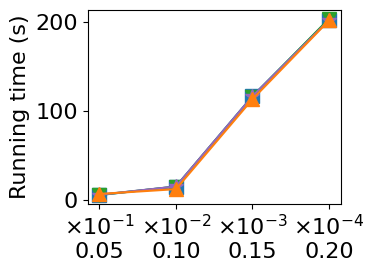

In [294]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Change initial parameters

## S+C+

In [295]:
tab = '(old change) supp inc|conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,0.7,20,8048,1407,492,2430,1000996,197.317298,192.114098,10.0,0.05,IncMiner0.7,8.048
1,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,0.7,20,2968,54,1904,1901,1000997,190.870518,190.613966,10.0,0.05,IncMiner0.7,2.968
2,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,0.7,20,555,21,1964,328,1000998,178.513611,178.405543,10.0,0.05,IncMiner0.7,0.555
3,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,0.7,20,319,13,1983,48,1000999,176.634746,176.554985,10.0,0.05,IncMiner0.7,0.319
4,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,NaN,20,8290,1407,492,2430,1001000,197.317298,192.114098,10.0,0.05,IncMiner,8.290
5,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,NaN,20,2824,54,1904,1901,1001001,190.870518,190.613966,10.0,0.05,IncMiner,2.824
6,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,NaN,20,546,21,1964,328,1001002,178.513611,178.405543,10.0,0.05,IncMiner,0.546
7,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,NaN,20,319,13,1983,48,1001003,176.634746,176.554985,10.0,0.05,IncMiner,0.319
8,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMinerNS,3,NaN,20,8213,1407,492,2348,1001004,196.662313,191.459113,10.0,0.05,IncMinerNS,8.213
9,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMinerNS,3,NaN,20,2960,54,1904,1796,1001005,190.047168,189.790616,10.0,0.05,IncMinerNS,2.960


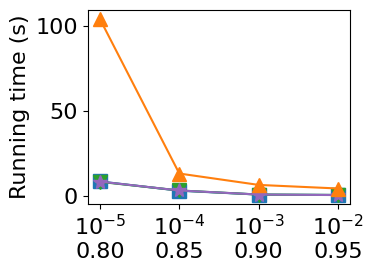

In [296]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

In [297]:
tab = '(old change) supp dec|conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,minimal REE number,prune REE number,sample number,taskId,output size,auxiliary size,supportScale,confDiff,label,time
0,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,0.7,20,7544,600,584,2755,1001013,174.288120,172.452763,0.1,-0.05,IncMiner0.7,7.544
1,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,0.7,20,8403,1621,261,2818,1001014,176.353885,171.475622,0.1,-0.05,IncMiner0.7,8.403
2,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,0.7,20,6028,3094,0,1346,1001015,164.628975,155.020039,0.1,-0.05,IncMiner0.7,6.028
3,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,0.7,20,4052,3427,0,0,1001016,153.180170,142.586802,0.1,-0.05,IncMiner0.7,4.052
4,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,NaN,20,8161,733,584,2755,1001017,174.686049,172.452763,0.1,-0.05,IncMiner,8.161
5,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,NaN,20,9563,2564,261,2818,1001018,179.066437,171.475622,0.1,-0.05,IncMiner,9.563
6,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,NaN,20,7287,4578,0,1346,1001019,168.989349,155.020039,0.1,-0.05,IncMiner,7.287
7,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,NaN,20,4555,3470,0,0,1001020,153.308921,142.586802,0.1,-0.05,IncMiner,4.555
8,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,11404,49,968,2744,1001021,195.157919,194.947219,0.1,-0.05,IncMinerNS,11.404
9,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMinerNS,3,NaN,20,15162,122,276,3299,1001022,265.285500,264.716959,0.1,-0.05,IncMinerNS,15.162


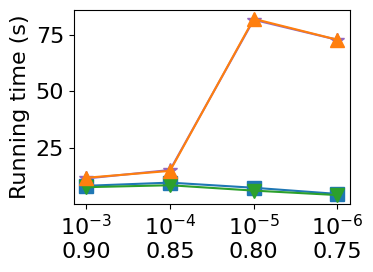

In [298]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label])
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()